In [82]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import wandb
import matplotlib.pyplot as plt
import numpy as np
from pytorchtools import EarlyStopping

ModuleNotFoundError: No module named 'pytorchtools'

In [26]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nata-vito. Use `wandb login --relogin` to force relogin


True

In [2]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(), 
)

100%|██████████| 26421880/26421880 [00:10<00:00, 2586399.75it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 135873.19it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1240250.10it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12178385.22it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [74]:
batch_size = 75

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of Y: {y.shape} {y.dtype}")
    break

dataiter = iter(train_dataloader)
images, labels = dataiter.__next__()
print(type(images))
print(images.shape)
print(labels.shape)

Shape of X [N, C, H, W]: torch.Size([75, 1, 28, 28])
Shape of Y: torch.Size([75]) torch.int64
<class 'torch.Tensor'>
torch.Size([75, 1, 28, 28])
torch.Size([75])


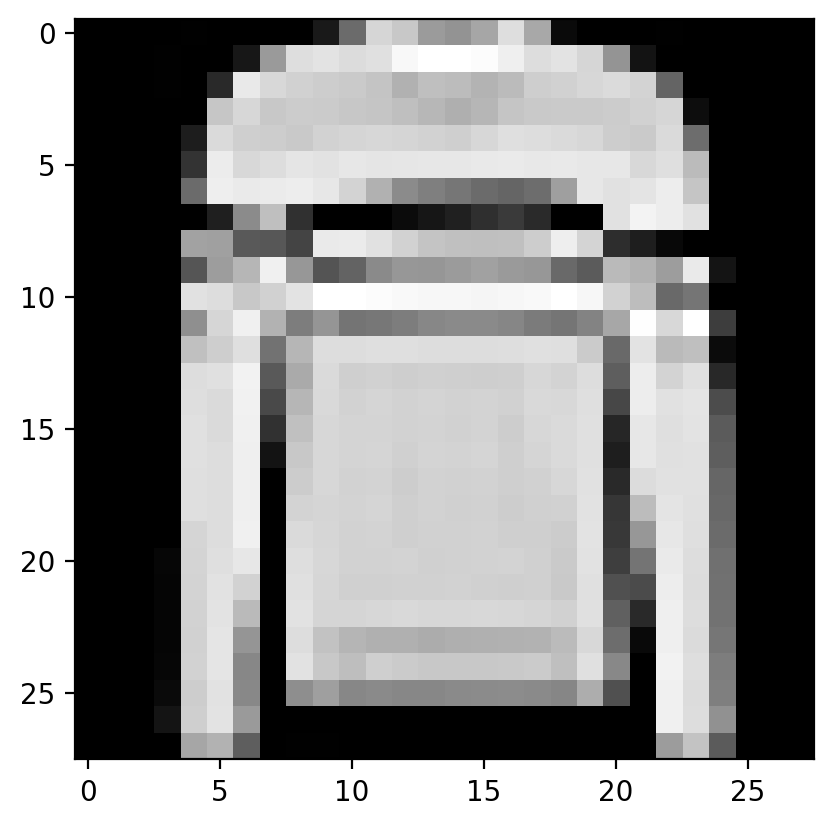

In [75]:
plt.imshow(images[5].numpy().squeeze(), cmap = 'Greys_r')

In [76]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [87]:
import copy
def train(dataloader, model, loss_fn, optimizer):
    #Initialize Variables for EarlyStopping
    best_loss = float('inf')
    best_model_weights = None
    patience = 10

    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
       
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

         # Early stopping
        if loss < best_loss:
            best_loss = loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                break

In [79]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    wandb.log({"Accuracy": (100*correct), "Avg loss": test_loss})

In [80]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [88]:
epochs = 100

run = wandb.init(
    project = "MPT-Defeitos-em-cabos",
    config = {
        "learning_rate": 1e-3,
        "epochs": epochs
    }
)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Accuracy,▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
Avg loss,█▆▅▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,84.26
Avg loss,0.44613


Epoch 1
-------------------------------
loss: 0.260512  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446094 

Epoch 2
-------------------------------
loss: 0.258635  [   75/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.446264 

Epoch 3
-------------------------------
loss: 0.257895  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446398 

Epoch 4
-------------------------------
loss: 0.257422  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446512 

Epoch 5
-------------------------------
loss: 0.257029  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446615 

Epoch 6
-------------------------------
loss: 0.256670  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446711 

Epoch 7
-------------------------------
loss: 0.256321  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446801 

Epoch 8
-------------------------------
loss: 0.255980  [   75/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.446884 

Epoch 9
----------------

### Saving pytorch models

In [34]:
torch.save(model.state_dict(), "./models/pytorch_model.pth")
print("Saved Pytorch Model State to pytorch_model.pth")

Saved Pytorch Model State to pytorch_model.pth


### Loading model

In [35]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("./models/pytorch_model.pth", weights_only = True))

<All keys matched successfully>

Predicted: Ankle boot, Actual: Ankle boot


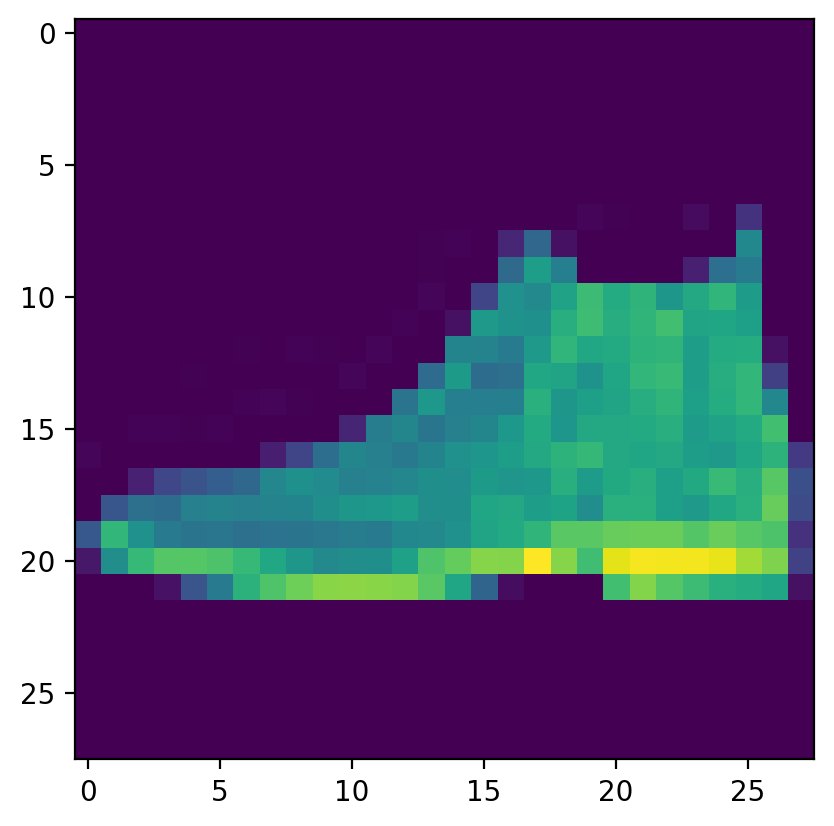

In [89]:
classes = [
    "T-shirt/top",
    "Trousser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()


x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: {predicted}, Actual: {actual}")
    plt.imshow(test_data[0][0].reshape((28,28)));


In [42]:
from enum import Enum

class State(Enum):
    sending = 0
    received = 1
    waiting = 2
    
Status = State.received
print(Status)

State.received
